# Assignment 8: Explainable Machine Learing (Part 1)

## Objective:

Interpreting how a machine learning model works is crucial from many aspects, such as debugging the model, improving the model, and derive new insights from the model. There are many model explanation techniques that we can use for interpreting a black box model itself or its predictions. Also, some models are transparent that we can directly get insights from its structure or learned parameters. In this assignment, you are going to train different models on a dataset and try different approaches to explain the model and get some insights. After completing this assignment, you should be able to answer the following questions:

1. How to explain transparent models?
2. How to implement the permutation method to explain black-box models?
3. How to create and interpret partial dependence plots?
4. How to implement the global surrogate method to explain black-box models?
5. How to use SHAP to explain model predictions and interpret its explanation results? 
6. How to use LIME to explain model predictions and  interpret its explanation results? 

The data can be downloaded from [A8-1-data.zip](A8-1-data.zip)



## 0. Preparation

Import relevant libraries and load the dataset:

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install dataprep
from dataprep.eda import plot

from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

     |████████████████████████████████| 3.7 MB 5.3 MB/s 
     |████████████████████████████████| 943 kB 51.8 MB/s 
     |████████████████████████████████| 10.9 MB 68.2 MB/s 
     |████████████████████████████████| 1.0 MB 66.5 MB/s 
     |████████████████████████████████| 1.5 MB 68.6 MB/s 
     |████████████████████████████████| 95 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 67.9 MB/s 
     |████████████████████████████████| 110 kB 81.1 MB/s 
     |████████████████████████████████| 133 kB 84.3 MB/s 
     |████████████████████████████████| 366 kB 80.6 MB/s 
     |████████████████████████████████| 743 kB 66.3 MB/s 
     |████████████████████████████████| 749 kB 59.2 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 78.5 MB/s 
     |████████████████████████████████| 271 kB 86.7 MB/s 
     |████████████████████████████████| 134 kB 78.4 MB/s 
     |████████████████████████████████| 289 kB 70.4 MB/s 
     |████████████

In [3]:
!pip install shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [4]:
!pip install lime

     |████████████████████████████████| 275 kB 5.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=35a9cc18afde88582581ff00d66be264b206f9d2cb2ddd7787ecde6154504b4a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


The dataset we are going to use is a binary forest covertype dataset and we will predict the forest cover type from cartographic variables only. The first ten features are numerical features, there are also two categorical features in a one-hot encoding fashion (4 and 40 vector length each), the last column is the target forest cover type (binary). More details about the dataset can be found at [https://archive.ics.uci.edu/ml/datasets/covertype](https://archive.ics.uci.edu/ml/datasets/covertype). Please make sure you understand the meaning of each feature.


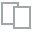
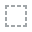
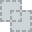
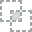
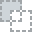
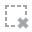
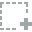
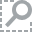
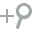
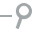
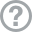
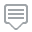
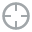
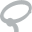
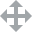
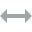
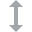
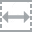
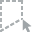
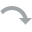
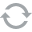
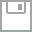
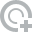
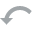
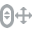
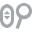
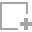
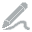
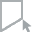
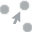
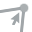
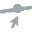

In [6]:
# load data and take a look at data distribution
data = pd.read_csv('bforest_sample.csv', delimiter=',')
plot(data)

In [7]:
# split data into training and test dataset with respect to ratio 0.8:0.2
train, test = train_test_split(data, test_size=0.2, random_state=733)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
feature_names = list(X_train)

# rescale
scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=feature_names)


## Task 1. Transparent Model

In this task, you are going to train a logistic regression model and interpret it. For logistic regression, since the effect of each feature is simply added together, we can interpret it directly by looking at the coefficient of each feature. Please follow the comment to finish the code:

In [8]:
# train a logistic regression model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [9]:
# set default figure size
plt.rcParams['figure.figsize'] = [16, 8]

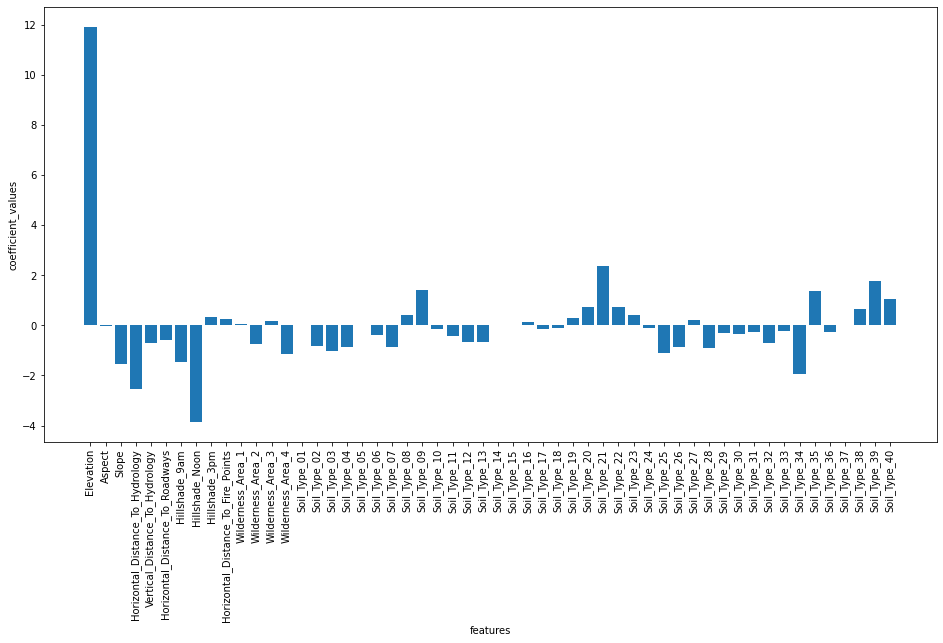

In [10]:
# show the coefficient value for each feature by a bar chart
def explain_logistic_regression(lr, feature_names):
    # --- Write your code below ---
    plt.bar(list(feature_names),lr.coef_[0])
    ax=plt.gca()
    ax.set_xticklabels(list(feature_names),rotation=90)
    plt.xlabel('features')
    plt.ylabel('coefficient_values')

# explain the model
explain_logistic_regression(lr, feature_names)

For a specific prediction, we can get a more concrete effect of each feature by the product of the coefficient and input feature value. Please follow the comment to finish the code:

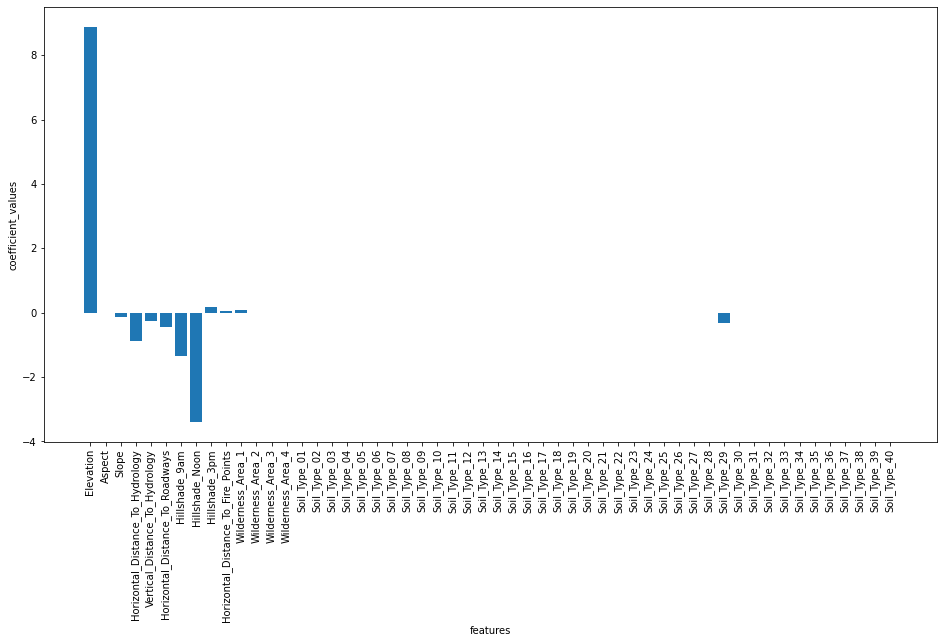

In [11]:
# show the effect from each input feature by a bar chart
def explain_logistic_regression_prediction(lr, feature_names, sample):
    # --- Write your code below ---
    plt.bar(list(feature_names),lr.coef_[0]*sample[0])
    ax=plt.gca()
    ax.set_xticklabels(list(feature_names),rotation=90)
    plt.xlabel('features')
    plt.ylabel('coefficient_values')

    
explain_logistic_regression_prediction(lr, feature_names, (X_test.iloc[0, :], y_test.iloc[0]))

What can you get from the above plots? Please write down two findings:

**Findings:**
1. Elevation has the highest amount of positive effect on output.
2. Only 11 features have a significance. Others are irrelevant.

## Task 2. Post-hoc Explanation (Global Model)

In this task, you are going to build a gradient boosting tree model and a neural network, and use some techniques we introduced in class to interpret these models. First, let's train the models using training data:

In [12]:
# train a gradient boosting classifier
gb = GradientBoostingClassifier().fit(X_train, y_train)

In [13]:
# train a multi-layer perceptron classifier
mlp = MLPClassifier(learning_rate_init=0.1).fit(X_train, y_train)

### 2.1 Permutation

In [14]:
# get importance score (E' - E) for each feature by permutation, use log_loss as error
def permutation_importance(model, feature_names, X, y):
    # calculate importance score for each feature by purmutation approach
    # --- Write your code below ---
    x1=log_loss(y,model.predict(X))
    log_y1=['' for x in range(len(feature_names))]
    for i in range(len(feature_names)):
      np.random.shuffle(X.T[i])
      x2=log_loss(y,model.predict(X))
      log_y1[i]=x2
    # show the top 5 most important features
    # --- Write your code below ---
    result=list(reversed(np.argsort(log_y1)[len(feature_names)-5:len(feature_names)]))
    for i in result:
      print(feature_names[i])
permutation_importance(gb, feature_names, X_test.to_numpy(), y_test.to_numpy())
permutation_importance(mlp, feature_names, X_test.to_numpy(), y_test.to_numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassi

Soil_Type_40
Soil_Type_39
Soil_Type_30
Soil_Type_29
Soil_Type_27


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid featu

Soil_Type_39
Soil_Type_40
Soil_Type_33
Soil_Type_34
Soil_Type_38


### 2.2 Partial dependence plots

In this section, you are going to use the [plot_partial_dependence](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html#sklearn.inspection.plot_partial_dependence) provided by sklearn to see the marginal effect of each single numerical features:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


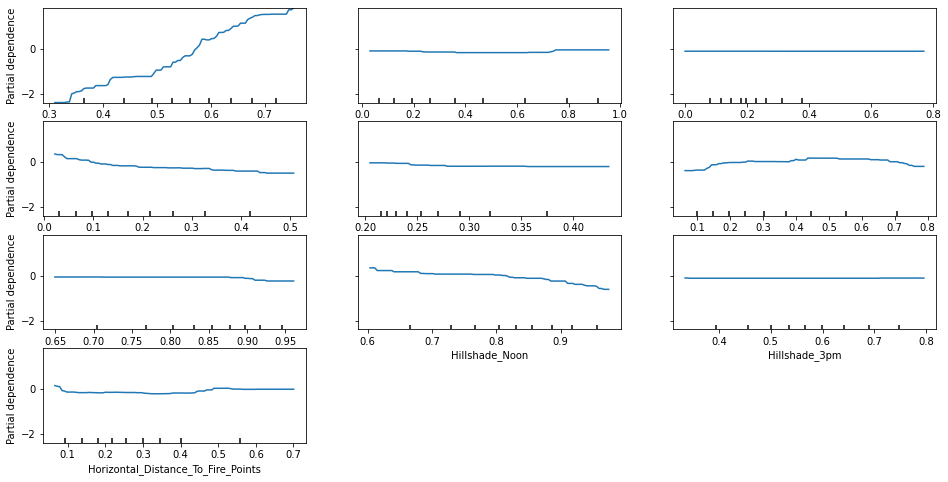

In [15]:
# plot partial dependence for numerical features (first 10 features) for gradient boosting classifier
# --- Write your code below ---
plot_partial_dependence(gb, X_test, feature_names[0:10])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


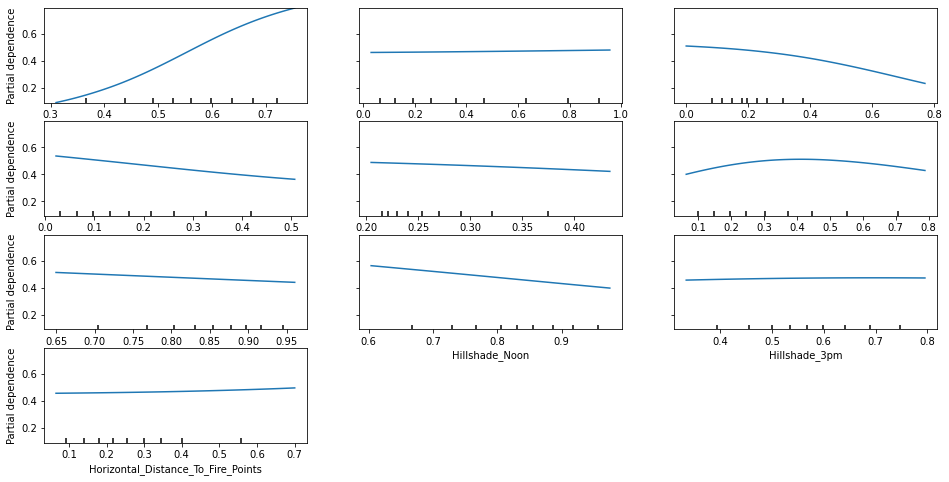

In [16]:
# plot partial dependence for numerical features (first 10 features) for neural network
# --- Write your code below ---
plot_partial_dependence(mlp, X_test, feature_names[0:10])

### 2.3 Global Surrogate

Now, let's train a simple logistic regression based on the gradient boosting tree model and neural network we built before. And use the method we implemented previously to interpret the derived transparent model:

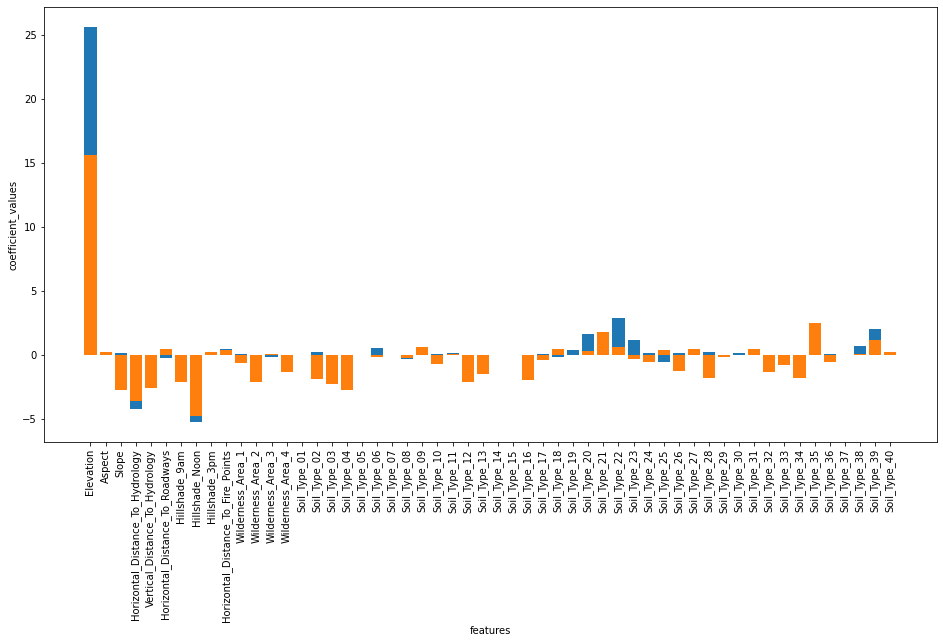

In [17]:
# train a logistic regression model on gb and mlp and explain using explain_logistic_regression()

# --- Write your code below ---

l1=LogisticRegression().fit(X_test,gb.predict(X_test))
l2=LogisticRegression().fit(X_test,mlp.predict(X_test))

explain_logistic_regression(l1,list(X_test))
explain_logistic_regression(l2,list(X_test))

## Task 3. Post-hoc Explanation (Single Prediction)

### 3.1 Attribution

From now, let's focus on interpreting single predictions. [SHAP](https://github.com/slundberg/shap) is an efficient method to approximatly calculate the shapely value we mentioned in class. Please install the library and take a look at the doc. Explain the first prediction made by the gradient boosting tree model in the test set:

In [21]:
import shap

# load JS visualization code to notebook
shap.initjs()

# use Tree SHAP explainer to explain the gradient boosting tree model
# you only need to explain and plot the first explaination
# --- Write your code below ---
shap_explainer=shap.TreeExplainer(gb)
shap_values=shap_explainer.shap_values(X_test)

# explain and plot the first explaination
shap.force_plot(shap_explainer.expected_value,shap_values[0],X_test.iloc[0])

What can you get from the above representation? Please write down two findings:

**Findings:**
1. Elevation has the highest amount of positive effect on output.
2. A lot of features have a minute effect on output.

### 3.2 LIME

[LIME](https://github.com/marcotcr/lime) is a library implemented by the authors of the paper. Please install the library and take a look at the doc and tutorial. Use it to explain the first prediction made by the neural network model in the test set:

In [19]:
import lime
import lime.lime_tabular
# use LimeTabularExplainer to explain the neural network model
# you only need to explain and plot the first explaination
# --- Write your code below ---

explainer=lime.lime_tabular.LimeTabularExplainer(X_test.values,feature_names=feature_names,discretize_continuous=True)
exp=explainer.explain_instance(data_row=X_test.values[0],predict_fn=mlp.predict_proba)
exp.show_in_notebook()

X does not have valid feature names, but MLPClassifier was fitted with feature names


Run LIME multiple times, (Q1) what do you think of the stability of LIME? (Q2) Can you briefly explain the reason?

**Your Answer:** 
1. In each run, weights of each feature changes. This continues for every run, signifying unstability.
2. On each run, lime fits the data points made randomly therefore it is unstable. Shap value guarantees a fair distribution of contribution for each of the variables (LIME do not provide the guarantee). LIME assumes that the local model is linear, SHAP does not have any such assumptions.

## Submission
Complete the code in this notebook, and submit it to the CourSys activity Assignment 8.